# LKM Recommendation System to Optimize HCP Email Engagement

#### Outline
1. Data preparation
2. Collaborative filtering recommendation system
3. Next steps

### Import packages

In [1]:
!pip install scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity

### Import data 

In [3]:
df = pd.read_csv('/Users/daniel/Desktop/Python/Projects/ML/AbbVie/case_study_dataset.csv')

### Review data types and null values 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570820 entries, 0 to 570819
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   country_id                  570820 non-null  object 
 1   activity_id                 570819 non-null  float64
 2   stakeholder_id              569328 non-null  float64
 3   activity_date               570820 non-null  object 
 4   channel                     570599 non-null  object 
 5   status                      570820 non-null  object 
 6   content_name                263942 non-null  float64
 7   content_global_key_message  263942 non-null  float64
 8   content_local_key_message   196396 non-null  float64
 9   potential_affinity          435492 non-null  object 
 10  adoption_ladder             251027 non-null  object 
dtypes: float64(5), object(6)
memory usage: 47.9+ MB


### Remove NA from columns with few NA data

In [5]:
df = df.dropna(subset=['stakeholder_id', 'activity_id'])

### Examine country_id variable

In [6]:
df['country_id'].value_counts()

country_id
DEU    569324
CAN         3
AUS         1
Name: count, dtype: int64

### Filter country_id by 'DEU'

In [7]:
df = df[df['country_id'] == 'DEU']

### Check distribution of status values for each channel  

In [8]:
summary = df.groupby(['channel','status']).size()
print(summary)

channel          status   
AbbVie-Pro       Sign-in           5
Approved E-mail  Bounced        3288
                 Clicked        2851
                 Delivered     47567
                 Opened        23910
E-mail           Saved           101
                 Submitted     76931
Engage Call      Saved           217
                 Submitted       415
Face to Face     Saved           712
                 Submitted    297406
Mass E-mail      Bounced        4143
                 Clicked        3237
                 Delivered     79506
                 Opened        13598
Telephone        Saved             9
                 Submitted     13749
Virtual/Video    Saved             5
                 Submitted      1453
dtype: int64


### Filter data for 'Delivered', 'Opened', and 'Clicked' status values

In [9]:
df = df[df['status'].isin(['Delivered', 'Opened', 'Clicked'])]

### Convert status to numerical values

In [10]:
df['status_numerical_value'] = df['status'].map({'Delivered': 0, 'Opened': 1, 'Clicked': 2})

### Convert activity_date to datetime to filter for the earliest activity_date of a LKM for each HCP 

In [11]:
df['activity_date'] = pd.to_datetime(df['activity_date'], format='mixed', dayfirst=False, utc=True)
df = df.loc[df.groupby(['stakeholder_id', 'content_local_key_message'])['activity_date'].idxmin()]

### Visualize Current HCP Email Engagement 

<Figure size 1000x600 with 0 Axes>

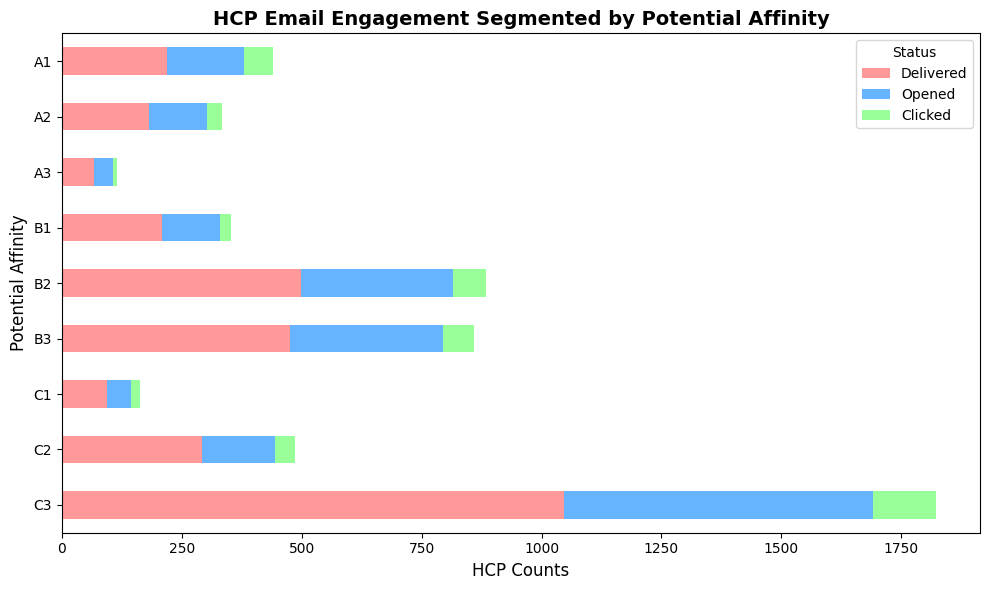

In [12]:
grouped_data = df.groupby(['potential_affinity', 'status'])['stakeholder_id'].nunique().reset_index()
grouped_data.rename(columns={'stakeholder_id': 'distinct_count'}, inplace=True)
grouped_data = grouped_data[~grouped_data['potential_affinity'].isin(['R','N'])]

segment_order = {'A1': 9, 'A2': 8, 'A3': 7, 'B1': 6, 'B2': 5, 'B3': 4, 'C1': 3, 'C2': 2, 'C3': 1}  
grouped_data['potential_affinity_order'] = grouped_data['potential_affinity'].map(segment_order)

pivot_data = grouped_data.pivot(index='potential_affinity', columns='status', values='distinct_count').fillna(0)

desired_column_order = ['Delivered', 'Opened', 'Clicked']
pivot_data = pivot_data[desired_column_order]

segment_order_series = grouped_data.drop_duplicates('potential_affinity').set_index('potential_affinity')['potential_affinity_order']
pivot_data = pivot_data.reindex(segment_order_series.sort_values().index)

plt.figure(figsize=(10, 6))
ax = pivot_data.plot(kind='barh', stacked=True, 
                     color=['#ff9999', '#66b3ff', '#99ff99'],  
                     figsize=(10, 6))

plt.title('HCP Email Engagement Segmented by Potential Affinity', fontsize=14, fontweight='bold')
plt.ylabel('Potential Affinity', fontsize=12)
plt.xlabel('HCP Counts', fontsize=12)
plt.legend(title='Status', loc='upper right')
plt.tight_layout()

<Figure size 1000x600 with 0 Axes>

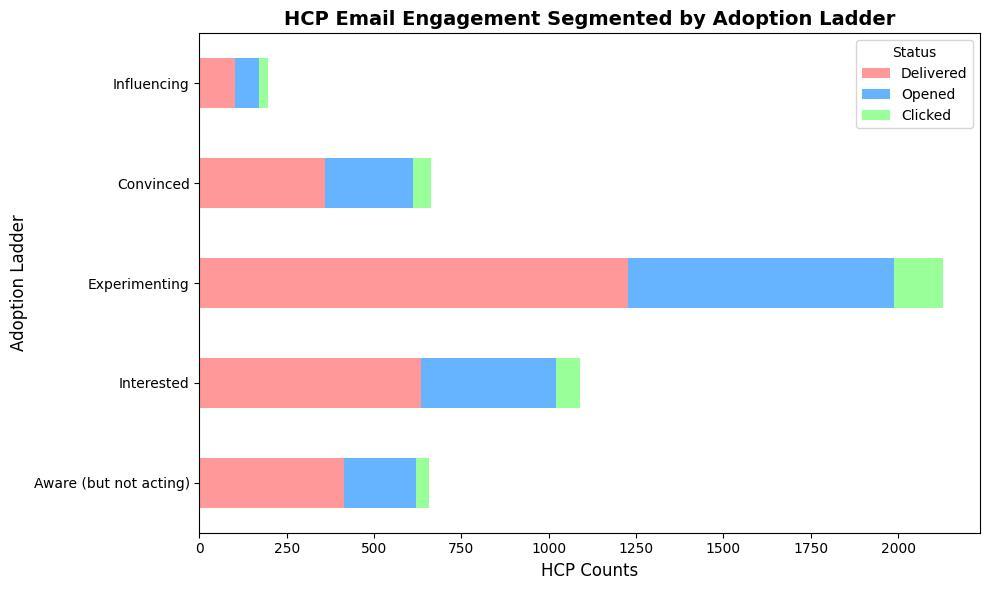

In [13]:
grouped_data = df.groupby(['adoption_ladder', 'status'])['stakeholder_id'].nunique().reset_index()
grouped_data.rename(columns={'stakeholder_id': 'distinct_count'}, inplace=True)
grouped_data = grouped_data[~grouped_data['adoption_ladder'].isin(['Converted','Unaware', 'Engaged'])]

segment_order = {'Influencing': 5, 'Convinced': 4, 'Experimenting': 3, 'Interested': 2, 'Aware (but not acting)': 1}  
grouped_data['adoption_ladder_order'] = grouped_data['adoption_ladder'].map(segment_order)

pivot_data = grouped_data.pivot(index='adoption_ladder', columns='status', values='distinct_count').fillna(0)

desired_column_order = ['Delivered', 'Opened', 'Clicked']
pivot_data = pivot_data[desired_column_order]

segment_order_series = grouped_data.drop_duplicates('adoption_ladder').set_index('adoption_ladder')['adoption_ladder_order']
pivot_data = pivot_data.reindex(segment_order_series.sort_values().index)

plt.figure(figsize=(10, 6))
ax = pivot_data.plot(kind='barh', stacked=True, 
                     color=['#ff9999', '#66b3ff', '#99ff99'],  
                     figsize=(10, 6))

plt.title('HCP Email Engagement Segmented by Adoption Ladder', fontsize=14, fontweight='bold')
plt.ylabel('Adoption Ladder', fontsize=12)
plt.xlabel('HCP Counts', fontsize=12)
plt.legend(title='Status', loc='upper right')
plt.tight_layout()

### Pivot data with stakeholder_id as the index and status_numerical_value for each LKM as the columns 

In [14]:
hcp_engagement_df = df.pivot(index='stakeholder_id', columns='content_local_key_message', values='status_numerical_value')
print(hcp_engagement_df)

content_local_key_message  1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   \
stakeholder_id                                                              
70.0                        NaN   NaN   NaN   0.0   NaN   NaN   NaN   NaN   
77.0                        0.0   1.0   1.0   0.0   NaN   NaN   NaN   1.0   
86.0                        0.0   NaN   NaN   NaN   NaN   0.0   NaN   NaN   
140.0                       NaN   NaN   NaN   NaN   NaN   0.0   NaN   NaN   
163.0                       NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   
...                         ...   ...   ...   ...   ...   ...   ...   ...   
9995.0                      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
10192.0                     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
10500.0                     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
10501.0                     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
10502.0                     NaN   NaN   NaN   NaN   NaN   2.0   NaN   NaN   

### Measure sparsity of data 

In [15]:
sparsity_count = hcp_engagement_df.isnull().values.sum()
full_count = hcp_engagement_df.size
sparsity = sparsity_count / full_count
print(f"{round(sparsity*100, 2)}%")

64.56%


### Find the average status_numerical_value for each HCP and center each value around the average 

In [16]:
avg_ratings = hcp_engagement_df.mean(axis=1)
hcp_engagement_df_centered = hcp_engagement_df.sub(avg_ratings, axis=0)
hcp_engagement_df_normalized = hcp_engagement_df_centered.fillna(0)
print(hcp_engagement_df_normalized)

content_local_key_message      1.0       2.0       3.0       4.0   5.0   \
stakeholder_id                                                            
70.0                       0.000000  0.000000  0.000000  0.000000   0.0   
77.0                      -0.357143  0.642857  0.642857 -0.357143   0.0   
86.0                      -0.142857  0.000000  0.000000  0.000000   0.0   
140.0                      0.000000  0.000000  0.000000  0.000000   0.0   
163.0                      0.000000  0.000000  0.000000  0.000000   0.0   
...                             ...       ...       ...       ...   ...   
9995.0                     0.000000  0.000000  0.000000  0.000000   0.0   
10192.0                    0.000000  0.000000  0.000000  0.000000   0.0   
10500.0                    0.000000  0.000000  0.000000  0.000000   0.0   
10501.0                    0.000000  0.000000  0.000000  0.000000   0.0   
10502.0                    0.000000  0.000000  0.000000  0.000000   0.0   

content_local_key_messag

### Transpose data with LKM as the index and status_numerical_value for each stakeholder as the columns

In [17]:
hcp_engagement_df_transposed = hcp_engagement_df_normalized.T
print(hcp_engagement_df_transposed)

stakeholder_id             70.0      77.0      86.0     140.0     163.0    \
content_local_key_message                                                   
1.0                            0.0 -0.357143 -0.142857      0.0  0.000000   
2.0                            0.0  0.642857  0.000000      0.0  0.000000   
3.0                            0.0  0.642857  0.000000      0.0  0.000000   
4.0                            0.0 -0.357143  0.000000      0.0  0.000000   
5.0                            0.0  0.000000  0.000000      0.0  0.000000   
6.0                            0.0  0.000000 -0.142857      0.0  0.166667   
7.0                            0.0  0.000000  0.000000      0.0  0.000000   
8.0                            0.0  0.642857  0.000000      0.0  0.000000   
9.0                            0.0  0.642857  0.857143      0.0  0.166667   
10.0                           0.0  0.642857  0.000000      0.0  0.000000   
11.0                           0.0 -0.357143 -0.142857      0.0  0.000000   

### Similarity matrix

In [18]:
similarities = cosine_similarity(hcp_engagement_df_transposed)
cosine_similarity_df = pd.DataFrame(similarities, index=hcp_engagement_df_transposed.index, columns=hcp_engagement_df_transposed.index)
print(cosine_similarity_df)

content_local_key_message      1.0       2.0       3.0       4.0       5.0   \
content_local_key_message                                                     
1.0                        1.000000 -0.092618 -0.038326 -0.001180 -0.041210   
2.0                       -0.092618  1.000000 -0.036067 -0.025334 -0.019528   
3.0                       -0.038326 -0.036067  1.000000 -0.043608 -0.005201   
4.0                       -0.001180 -0.025334 -0.043608  1.000000  0.035526   
5.0                       -0.041210 -0.019528 -0.005201  0.035526  1.000000   
6.0                       -0.154357 -0.082955 -0.074370 -0.029922 -0.027313   
7.0                       -0.047933  0.018323  0.014688 -0.016959  0.101795   
8.0                       -0.032373 -0.063021 -0.045669  0.020842 -0.057037   
9.0                       -0.167449 -0.035931 -0.100834 -0.052317 -0.098205   
10.0                      -0.067380 -0.042645  0.034557 -0.063890  0.012954   
11.0                       0.003387 -0.047141  0.007

### Input HCP and the latest LKM that led to successful engagement for similar LKMs

In [19]:
HCP = 77.0
prior_LKM = 13.0

cosine_similarity_series = cosine_similarity_df.loc[prior_LKM]  
ordered_similarities = cosine_similarity_series.sort_values(ascending=False)
ordered_similarities = ordered_similarities.drop(prior_LKM, errors='ignore')
hcp_filter_df = hcp_engagement_df.T
null_hcp_indices = hcp_filter_df[hcp_filter_df[HCP].isnull()].index
filtered_similarities = ordered_similarities[ordered_similarities.index.isin(null_hcp_indices)]

print('Top recommended LKM:', filtered_similarities)

Top recommended LKM: content_local_key_message
7.0     0.021338
6.0    -0.047110
5.0    -0.079630
18.0   -0.098470
Name: 13.0, dtype: float64


### Input a LKM to predict the most probable outcome of engagement using KNN

In [20]:
new_LKM = 7.0

hcp_engagement_df_normalized.drop(new_LKM, axis=1, inplace=True)
target_hcp_x = hcp_engagement_df_normalized.loc[[HCP]]
other_hcp_y = hcp_engagement_df[new_LKM]
other_hcp_x = hcp_engagement_df_normalized[other_hcp_y.notnull()]
other_hcp_y.dropna(inplace=True)

hcp_knn = KNeighborsClassifier(metric='cosine', n_neighbors=3)

hcp_knn.fit(other_hcp_x, other_hcp_y)
hcp_hcp_pred = hcp_knn.predict(target_hcp_x)

print(hcp_hcp_pred, '0. = Delivered, 1. = Opened, 2. = Clicked')

[1.] 0. = Delivered, 1. = Opened, 2. = Clicked


### Next Steps
1. Use text data from LKM to develop content-based recommendation systems
2. Build a user interface for the recommendation systems to make it easier and accessible for sales reps to use 
3. Collect more data over time to improve model performance and examine if a LKM recommendation system can significantly improve HCP engagement 